# HW3

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Plot settings

In [2]:
sns.set_style('darkgrid')
sns.set_palette('deep')
sns.set_color_codes('deep')
sns.set_context('paper')
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

## Problem 1: Linear Regression Class [40pts]

### Part 1: Base Class

In [3]:
class Regression(object):
    
    def __init__(self):
        self.params = {}
    
    def get_params(self):
        # return best fit params (B-hat) from fit()
        return self.params
    
    def set_params(self, **kwargs):
        """Set params in subclass"""
        raise NotImplementedError
    
    def fit(self, X, y):
        # fits linear model supplied from subclass to X and y 
        # and stores best fit coeffs (b_hat) in params dict
        """Fit model in subclass"""
        raise NotImplementedError
    
    def predict(self, X):
        # get best fit coeffs from params dict and convert to column vector
        beta = self.params
        beta = np.concatenate(([beta['intercept']], beta['coeffs']))
        beta = np.array([beta]).T # convert to column vector
        
        # prepend the column of ones to design matrix
        nrows = X.shape[0]
        intercept_ones = np.ones(nrows)
        X = np.column_stack((intercept_ones, X))
        
        # y = X B + epsilon
        y_pred = X.dot(beta)
        y_pred = y_pred.T[0] # convert back to 1D array R_sq
        return y_pred
            
    def score(self, X, y):
        y_pred = self.predict(X)

        # score statistics
        y_bar = np.mean(y)
        SS_E = np.sum((y - y_pred)**2)
        SS_T = np.sum((y - y_bar)**2)
        R_sq = 1 - SS_E / SS_T
        return(R_sq)
    
    def plot_prediction(self, ax, y_pred, y_test):
        ax.plot(y_pred, 'r', label='prediction') # prediction
        ax.plot(y_test, 'b', label='test') # test
        ax.legend(loc='best')
        return ax

## Part 2: OLS Linear Regression

In [4]:
class LinearRegression(Regression):
    
    def __init__(self):
        self.M = 0
        super().__init__() # to maintain access to params dict
        
    def fit(self, X, y):
        # create design matrix (padding with ones column)
        if X.ndim == 1: # just duplicate the same observation
            X = np.insert(X, 0, 1)
            X = np.tile(X, (len(X), 1))
        else:
            num_rows = X.shape[0]
            intercept_ones = np.ones(num_rows)
            X = np.column_stack((intercept_ones, X))
        
        # compute B_hat
        X_inv = np.linalg.pinv(X)
        y = np.array([y]).T # convert to column vector
        B_hat = np.linalg.pinv(X.T.dot(X) + self.M).dot(X.T).dot(y)
        
        # return params
        B_hat = B_hat.ravel() # convert to 1D array
        self.params['coeffs'] = B_hat[1:]
        self.params['intercept'] = B_hat[0]

### Part 3: Ridge Regression

In [5]:
class RidgeRegression(LinearRegression):
    def __init__(self, alpha=0.1):
        super().__init__() # get access to params dict
        self.alpha = alpha
        self.M = self.ridge_mod()
        
    def ridge_mod(self): 
        # modifies Bhat calculation done in OLS
        
        # Gamma = alpha * I
        # The +1 accounts for extra column of 1's to give I the right dimensions
        Gamma = self.alpha*np.identity(len(X.T.dot(X)) + 1)
        return Gamma.T.dot(Gamma)  # overwrite default OLS M=0
        #return alpha**2
    
    def set_params(self, **kwargs):
        self.alpha = kwargs['alpha']
        self.M = self.ridge_mod() # update

### Part 4: Model Scoring

#### Import the data

In [6]:
from sklearn import datasets
dataset = datasets.load_boston()

#### Poke around inside

In [7]:
# just looking at everything stored inside the dict
for k, v in dataset.items():
    print(f"{k} {np.shape(v)}:\n")

data (506, 13):

target (506,):

feature_names (13,):

DESCR ():



In [8]:
print(dataset['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

The dataset description in `dataset['DESCR']` tells us that there are 14 columns, but there are only 13 in `dataset.data` according to its shape though. This means that the 14th column is probably stored in the only other key whose value is a 1-D array, `dataset['target']` . This is also noted as "Median Value (attribute 14) is usually the target" in the `DESCR` field. I'll just tack this on to the end of the 2-D array and display it as a `pandas` DataFrame.

In [9]:
import pandas as pd
pd.options.display.max_rows = 10 # reduce how many rows are shown

# I'm not using dot notation to access data and feature names because I am pretending that dataset is a dict and not an sklearn object for this HW.
dataset = datasets.load_boston()
X = dataset['data']
y = dataset['target']
col_names = dataset['feature_names']
df = pd.DataFrame(X, columns=col_names)
df['target'] = y
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Ok, so it looks like each row is the stats for a town (or collection of homes?) and each column are some corresponding stats, with the last one being the median price in that particular  town in the  $1000's$.  

Recasting this as a linear regression problem: for any given town $i$, $y_i$ is the observed target median price corresponding to homes in that town and $x_{ij}$ is the $j$th statistic that was also measured for town $i$, corresponding to the $j$th column in row $i$ of the table shown above. For the $p$ regressors (number of columns, not including the target column), 

\begin{align}
    y_i = \sum_{j=0}^{p} x_{ij}\beta_j + \epsilon_i\ , 
    (i = 1,2,\dots, m)\ ,
\end{align}

where  $m$ is the number of towns (observations), $\beta_i$ is some scalar coefficient, $\epsilon_i$ is/are some unobserved random variable/s that account for influences on $y_i$ other than the collection of regressors $x_i$ that we happen to know about. Setting $x_{i0} = 1$ allows $(\beta_0)$ to act  as our intercept. In matrix form, all of the $m$ models (number of rows in the table) can compactly be written as
\begin{align}
    \boldsymbol y = \boldsymbol X \boldsymbol\beta + \boldsymbol\epsilon
    \ ,
\end{align}

where $\boldsymbol y$ is a column vector with length $m$, $\boldsymbol X$ is an $m\times n$ (design) matrix (where $n=p+1$, since it's just the data table above with a first column of ones and minus the target column), and $\boldsymbol\beta$ and $\boldsymbol\epsilon$ are also column  vectors of length $m$ composed of the $\beta_i$'s and $\epsilon_i$'s mentioned above. 

#### Game plan

Alright, I'm going to use the first 405 models ($\approx 80\%$ of the data) as my training set to determine the best fit coefficients $\boldsymbol{\hat\beta}$ found from OLS and Ridge to test on the reminaing 101 models, respectively, and score how well each predictive model does on the remaing 101 models in predicting the target housing price $y_i$.

In [10]:
# just reloading data just in case upper cells weren't run
dataset = datasets.load_boston()
X = dataset['data']
y = dataset['target']
def train_test_split(data, target, f=0.2, shuffle=False):
    # splits data into training and test set
    
    if shuffle:
        X_y = np.c_[data, target] # makes sure X and y rows stay together
        np.random.shuffle(X_y)
        data, target = X_y[:,:-1], X_y[:,-1]
        
    num_train = int(round((1-f)*len(X))) # number of training models
    
    # training set
    X_train = data[0:num_train, :]
    y_train = target[0:num_train]
    
    # test set
    X_test = data[num_train:, :]
    y_test = target[num_train:]
    return X_train, X_test, y_train, y_test

# just reloading data just in case upper cells weren't run
dataset = datasets.load_boston()
X = dataset['data']
y = dataset['target']
# train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    f=0.2, 
                                                    shuffle=True)

# run fits and display info in table
alpha = 0.1 # for Ridge
width = 50 # number of dashed lines in output

models = [LinearRegression(), RidgeRegression(alpha)]
model_names, y_preds, Rs = [], [], []
for model in models:
    model_name = model.__class__.__name__
    model_names.append(model_name)
    print(f"Stats for: {model_name}")
    print("-"*width)
    model.fit(X_train, y_train)
    y_preds.append(model.predict(X_test)) # for plotting
    score = model.score(X_test, y_test)
    Rs.append(score)
    beta = model.get_params()
    print(f"R^2: {score}\n")
    
    print("(Regressor coefficients):")
    for regressor, coeff in zip(col_names, beta['coeffs']):
        print(f"{regressor}: {coeff}")
    
    print(f"\nIntercept: {beta['intercept']}\n\n")

Stats for: LinearRegression
--------------------------------------------------
R^2: 0.7343552502395325

(Regressor coefficients):
CRIM: -0.08297968194228426
ZN: 0.04522442665794951
INDUS: 0.042807486040178644
CHAS: 3.0377067536899722
NOX: -17.48285312036574
RM: 3.901887918571836
AGE: 0.003886127292400697
DIS: -1.4922513231845693
RAD: 0.2829546142176674
TAX: -0.012023290791912543
PTRATIO: -0.9759824800244531
B: 0.010396623012992013
LSTAT: -0.5674948392050202

Intercept: 35.887827240779146


Stats for: RidgeRegression
--------------------------------------------------
R^2: 0.7341128197816988

(Regressor coefficients):
CRIM: -0.08238510108342727
ZN: 0.04528504082922162
INDUS: 0.041944654834287665
CHAS: 3.044222653921349
NOX: -17.114297626540875
RM: 3.9333321527399745
AGE: 0.0036281246589722205
DIS: -1.4824611060471327
RAD: 0.2802996384484383
TAX: -0.011987046372899482
PTRATIO: -0.9662697788099224
B: 0.010488692762000732
LSTAT: -0.566264384204535

Intercept: 35.25493527936156




As a quick sanity check, here is what the predicted vs actual housing price values look like for the test set for both linear regression models.

<IPython.core.display.Javascript object>


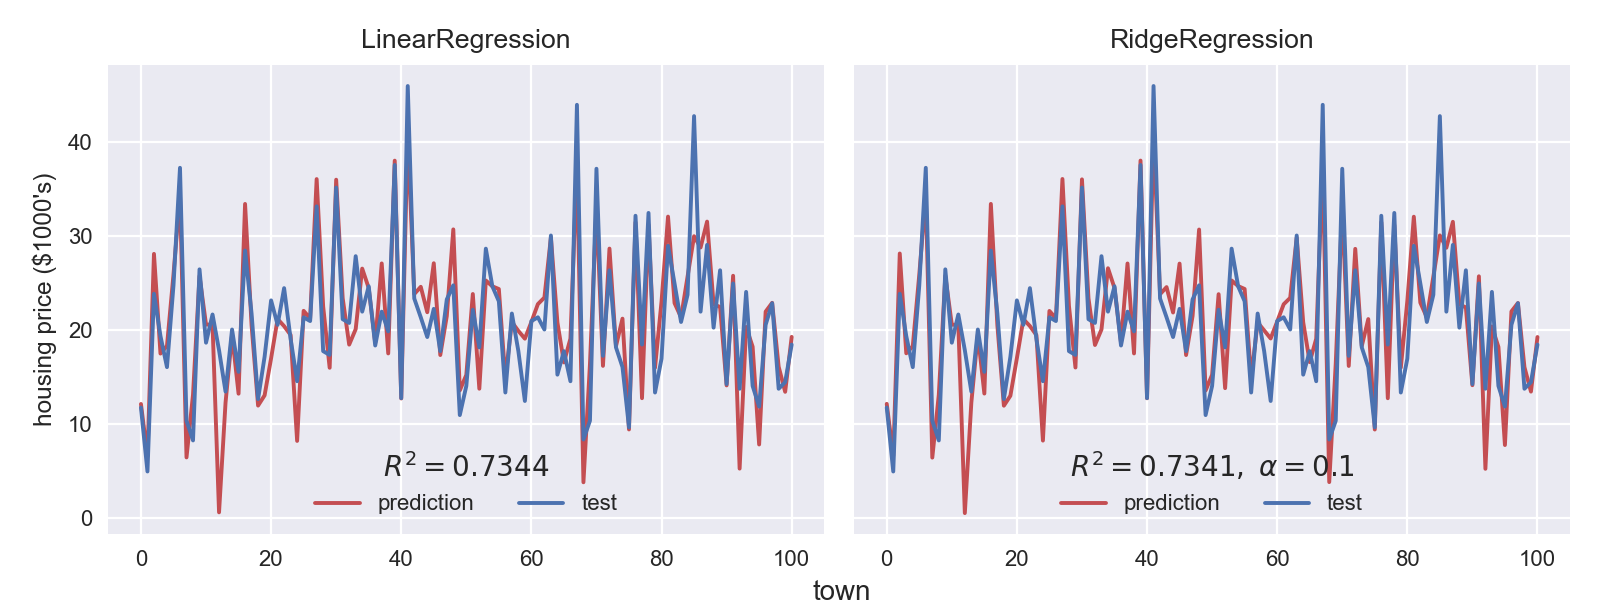

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

for ax, model_name, y_pred, R in zip(axes, model_names, y_preds, Rs):
    ax = model.plot_prediction(ax, y_pred, y_test)
    ax.set_title(model_name)

    if model_name == 'LinearRegression':
        leg_title = f'$R^2 = {R:.4f}$'
    else:
        leg_title = f'$R^2 = {R:.4f},\ \\alpha={alpha}$'

    ax.legend(loc='best', ncol=2, title=leg_title)

axes[0].set_ylabel("housing price ($1000's)")
fig.text(0.508, 0, "town")
fig.tight_layout()

### Part 5: Visualize Model Performance

<IPython.core.display.Javascript object>


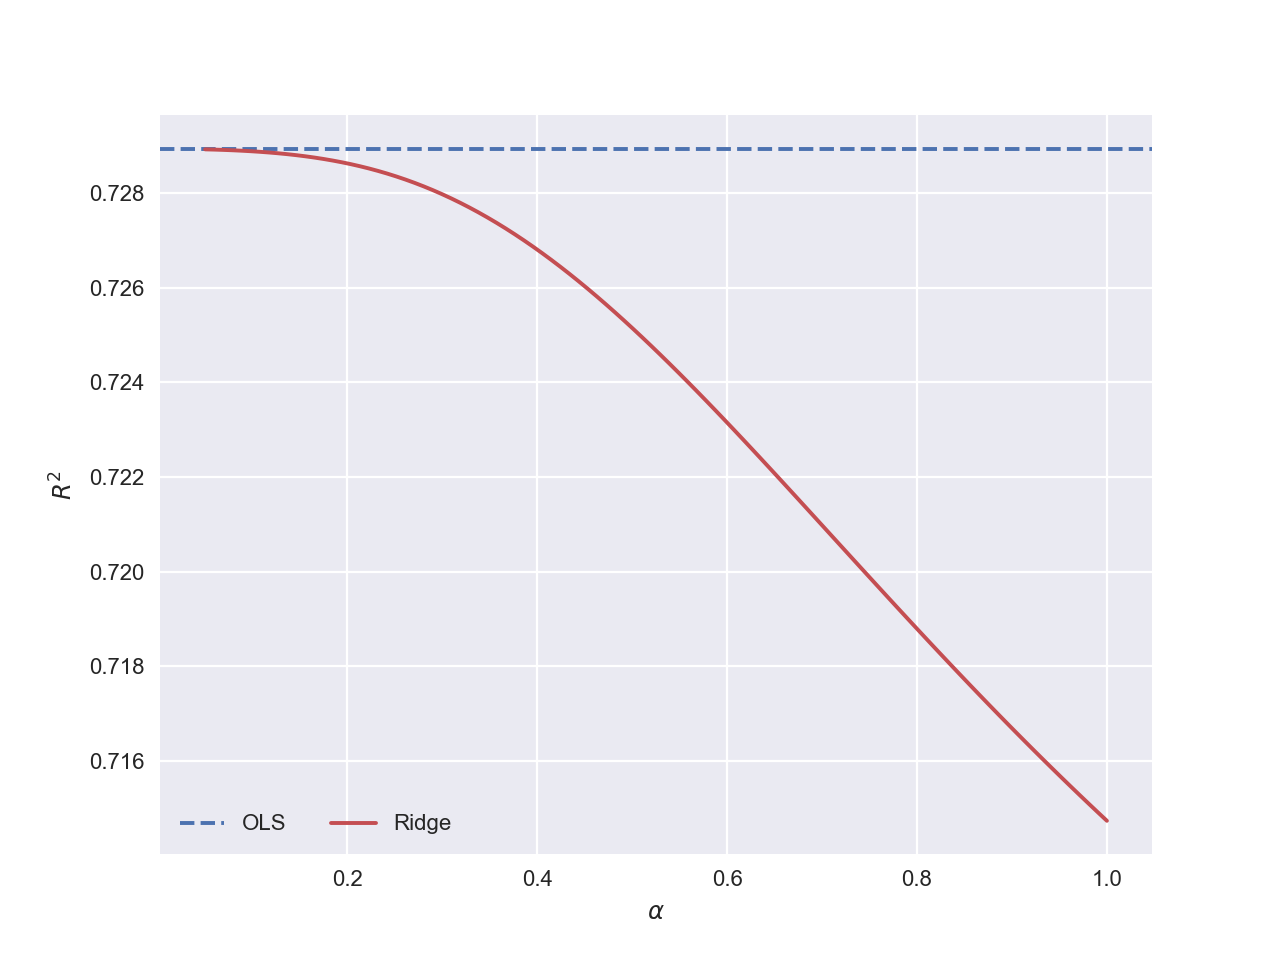

Text(0,0.5,'$R^2$')

In [12]:
# just reloading data just in case upper cells weren't run
dataset = datasets.load_boston()
X = dataset['data']
y = dataset['target']
# train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    f=0.2, 
                                                    shuffle=True)
# get OLS score
model = LinearRegression()
model.fit(X_train, y_train)
score_OLS = model.score(X_test, y_test)

# get Ridge scores
alphas = np.linspace(0.05, 1, 100)
scores_ridge = []
for alpha in alphas:
    model = RidgeRegression()
    model.set_params(alpha=alpha) # update default alpha=0.1
    model.fit(X_train, y_train)
    score_ridge = model.score(X_test, y_test)
    scores_ridge.append(score_ridge)
    
# plot
fig, ax = plt.subplots()
ax.axhline(score_OLS, ls='--', label='OLS') # OLS
ax.plot(alphas, scores_ridge, 'r', label='Ridge') # Ridge
ax.legend(loc='best', ncol=2)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$R^2$')

## Problem 2 [10pts]

### Part 1: Create a module

Included in directory as `MathCS207.py`

### Part 2: Import a whole module and use it

In [13]:
import MathCS207

# inputs
inputs = {'a':10., 'b':2.}

# show output from module
print(
    f"inputs: {inputs}\n----------------------------\n"
    f"addition (a + b): {MathCS207.add(**inputs)}\n"
    f"subtraction (a - b): {MathCS207.subtract(**inputs)}\n"
    f"multiplication (a*b): {MathCS207.multiply(**inputs)}\n"
    f"division (a/b): {MathCS207.divide(**inputs)}"
)

inputs: {'a': 10.0, 'b': 2.0}
----------------------------
addition (a + b): 12.0
subtraction (a - b): 8.0
multiplication (a*b): 20.0
division (a/b): 5.0


### Part 3: Import a single function from a module and use it

In [14]:
from MathCS207 import add

print(add(**inputs))

12.0


### Part 4: Import a module by creating an alias of it and then use the alias

In [15]:
import MathCS207 as mathcs

print(mathcs.add(**inputs))

12.0


### Part 5: List every function definition inside the module MathCS207

In [16]:
print(dir(MathCS207))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add', 'divide', 'multiply', 'subtract']


## Problem 3: Bank Account Revisited [50pts]

#### Defining `SAVINGS` and `CHECKING` bank accounts

In [17]:
from enum import Enum
class AccountType(Enum):
    SAVINGS = 1
    CHECKING = 2

### Part 1: Create a BankAccount class

In [18]:
class BankAccount():
    
    def __init__(self, owner, accountType):
        self.owner = owner
        self.accountType = accountType
        self.balance = 0 # start with zero balance for new accounts
        
    def withdraw(self, amount): 
        if amount > self.balance:
            print('Insufficient funds.')
        elif amount < 0:
            print('Must withdraw positive amount.')
        else:
            self.balance -= amount
    
    def deposit(self, amount):
        if amount <= 0: 
            print('Please enter a positive amount.')
        else:
            self.balance += amount
        
    def __str__(self):
        return(f"Account owner: {self.owner}\n"
               f"Account type : {self.accountType.name}")
        
    def __len__(self):
        return self.balance

### Part 2: Write a class BankUser

In [19]:
class BankUser():
    
    def __init__(self, owner):
        self.owner = owner
        self.accounts = {}
    
    def addAccount(self, accountType):
        if accountType.name not in self.accounts.keys():
            account = BankAccount(self.owner, accountType) 
            self.accounts[accountType.name] = account
        else:
            # don't add duplicate account
            print(f"{accountType.name} already created")
        
    def getBalance(self, accountType):
        if accountType.name in self.accounts.keys():
            balance = self.accounts[accountType.name].__len__()
            print(f"Balance: {balance}")
        else:
            print(f"Account not created")
    
    def deposit(self, accountType, amount):
        if accountType.name in self.accounts.keys():
            print('in here')
            self.accounts[accountType.name].deposit(amount)
        else:
            print(f"Account not created")
        
    def withdraw(self, accountType, amount):
        if accountType.name in self.accounts.keys():
            self.accounts[accountType.name].withdraw(amount)
        else:
            print(f"Account not created")
    
    def __str__(self):
        print(f"Account owner: {self.owner}")
        for account_type, account in self.accounts.items():
            print(f"{account_type}: ${account.__len__()}")

#### Trying some test cases

In [20]:
print('* deposit and withdraw normal amounts')
user = BankUser('Mr. Foo')
# checking
user.addAccount(AccountType.CHECKING)
user.deposit(AccountType.CHECKING, 100)
user.withdraw(AccountType.CHECKING, 10)
# savings
user.addAccount(AccountType.SAVINGS)
user.deposit(AccountType.SAVINGS, 1000)
user.withdraw(AccountType.SAVINGS, 100)
user.__str__()

print('\n* deposit and withdraw multiple normal amounts')
user = BankUser('Mr. Foo')
# checking
user.addAccount(AccountType.CHECKING)
user.deposit(AccountType.CHECKING, 50)
user.deposit(AccountType.CHECKING, 50)
user.withdraw(AccountType.CHECKING, 5)
user.withdraw(AccountType.CHECKING, 5)
# savings
user.addAccount(AccountType.SAVINGS)
user.deposit(AccountType.SAVINGS, 500)
user.deposit(AccountType.SAVINGS, 500)
user.withdraw(AccountType.SAVINGS, 50)
user.withdraw(AccountType.SAVINGS, 50)
user.__str__()

print('\n* Try to overdraw from checking. Should say "insufficient funds" and leave original balance untouched.')
user = BankUser('Mr. Foo')
# checking
user.addAccount(AccountType.CHECKING)
user.deposit(AccountType.CHECKING, 100)
user.withdraw(AccountType.CHECKING, 500)
user.__str__()

print('\n* Try to deposit negative amount. Should say "please enter positive amount"')
user = BankUser('Mr. Foo')
# checking
user.addAccount(AccountType.CHECKING)
user.deposit(AccountType.CHECKING, 100)
user.deposit(AccountType.CHECKING, -500)

print('\n* Try to open an additional account')
print('should print duplicate account error and show which account')
user = BankUser('Mr. Foo')
# checking
user.addAccount(AccountType.CHECKING)
user.addAccount(AccountType.CHECKING)

* deposit and withdraw normal amounts
in here
in here
Account owner: Mr. Foo
CHECKING: $90
SAVINGS: $900

* deposit and withdraw multiple normal amounts
in here
in here
in here
in here
Account owner: Mr. Foo
CHECKING: $90
SAVINGS: $900

* Try to overdraw from checking. Should say "insufficient funds" and leave original balance untouched.
in here
Insufficient funds.
Account owner: Mr. Foo
CHECKING: $100

* Try to deposit negative amount. Should say "please enter positive amount"
in here
in here
Please enter a positive amount.

* Try to open an additional account
should print duplicate account error and show which account
CHECKING already created


## Part 3

In [21]:
def ATMSession(bankUser):
    def Interface():
        def main_exit():
            print('Exiting session...')
            return False
            
        def main_create_account():
            return bankUser.addAccount(accountType)
    
        def main_check_balance():
            bankUser.getBalance(accountType)
            
        def main_deposit():
            deposit_amount = int(input('Deposit amount:'))
            bankUser.deposit(accountType, deposit_amount)
            
        def main_withdraw():
            withdrawal_amount = int(input('Withdrawal amount:'))
            bankUser.withdraw(accountType, withdrawal_amount)
        
        # print options of menu dictionary
        def print_menu(menu):
            for option_num, option in menu.items():
                print(f'{option_num}){option}\n')
        def print_main():
            main = {1:'Exit', 2:'Create Account', 3:'Check Balance', 
                       4:'Deposit', 5:'Withdraw'}
            print('Enter Option:\n')
            print_menu(main)  
            print()
        def print_sub():
            sub = {1:'Checking', 2:'Savings'}
            print_menu(sub)
        
        # main menu
        menu_main = {'1':main_exit, 
                     '2':main_create_account,
                     '3':main_check_balance, 
                     '4':main_deposit,
                     '5':main_withdraw} 
        loop = True
        while(loop or loop==None): 
            print()
            print_main() # print main menu
            # read user input to main menu
            input_main = input()
            if input_main == '1': 
                loop = menu_main[input_main]()
            elif input_main in menu_main.keys():
                try:
                    print_sub()  # print sub menu
                    input_sub = input() # read user input to sub menu
                    if input_sub == '1':
                        accountType = AccountType.CHECKING
                        loop = menu_main[input_main]() # run sub-menu
                    elif input_sub == '2':
                        accountType = AccountType.SAVINGS
                        loop = menu_main[input_main]() # run sub-menu
                    else: 
                        print('Not valid input')
                        loop = True # go back to main menu
                except KeyError:
                    print('Not valid input')
                    loop = True # just go to main menu again
            else:
                print('Not valid input')
                loop = True # return to main menu
    return Interface

user = BankUser('Mr. Foo')
atm = ATMSession(user)
atm()


Enter Option:

1)Exit

2)Create Account

3)Check Balance

4)Deposit

5)Withdraw


1
Exiting session...
